# Scoring products of Digikala

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
digikala = pd.read_csv('new_comments.csv',  )
digikala.head()

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,likes,dislikes,seller_title,seller_code,true_to_size_rate,advantages_count,disadvantages_count
0,53672599,1,3,23 شهریور 1402,1.0,1.0,True,252058,0,0,دیجی‌کالا,5A52N,0,0,0
1,9897229,1,10,16 تیر 1399,0.0,1.0,True,252058,1,0,دیجی‌کالا,5A52N,0,1,1
2,38074516,1,19,26 مرداد 1401,0.0,1.0,True,3331597,0,0,آرالیا بیوتی,ADM47,0,0,0
3,18628562,1,18,28 اسفند 1399,0.0,1.0,True,3331329,0,0,اینجاست آ,9ZMCZ,0,0,0
4,53301258,1,19,12 شهریور 1402,3.0,1.0,True,3255700,0,0,گالری آرایشی به سیما,CDWHA,0,0,0


In [3]:
digikala.describe()

,id,title,body,rate,recommendation_status,product_id,likes,dislikes,true_to_size_rate,advantages_count,disadvantages_count
count,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06,6.156289e+06
mean,3.704709e+07,5.346122e-01,1.008899e+01,3.648286e+00,8.064603e-01,3.908983e+06,4.503171e-01,8.687068e-02,1.474476e-02,2.183842e-01,8.682617e-02
std,1.393243e+07,4.988006e-01,1.336516e+01,1.861854e+00,3.632568e-01,3.015881e+06,2.294114e+00,8.313516e-01,1.205295e-01,7.193426e-01,3.718175e-01
min,9.815860e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.602000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.731234e+07,0.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,1.532375e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.044773e+07,1.000000e+00,6.000000e+00,4.000000e+00,1.000000e+00,3.183184e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.897122e+07,1.000000e+00,1.200000e+01,5.000000e+00,1.000000e+00,5.992988e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.474516e+07,1.000000e+00,9.080000e+02,2.500000e+03,1.000000e+00,1.270221e+07,1.136000e+03,3.360000e+02,1.000000e+00,3.200000e+01,1.700000e+01


# Exploring Data

## Comments Length Analyis
I want to declare Intervals for scoring on comments lenrgth. here is three method :
1. Heuristic-Based
2. Percentile-Based
3. Clustering-Based

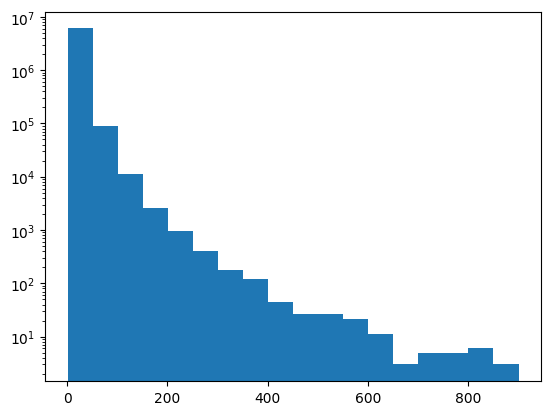

In [11]:
comments = digikala['body']
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
plt.show()

In [8]:
import bisect
from collections import defaultdict

def score_comment(intervals, length):
    return bisect.bisect_left(intervals, length)

def total_score_comment(intervals, lengths):
    sum = 0
    lengths_dict = defaultdict(list)
    for length in lengths:
        score = score_comment(intervals, length)
        sum += score
        lengths_dict[score].append(length)

    lengths_stats = {}
    for score, lengths in lengths_dict.items():
        lengths_stats[score] = {
            'num' : len(lengths),
            'mean': np.mean(lengths),
            'std': np.std(lengths),
            'sum' : np.sum(lengths)
        }
    return lengths_stats, sum

In [54]:
# check function
intervals = [0, 1, 5, 10]
lengths = [0,0,1,2,2,3,6,4,6,20,23,43]

lengths_stats, sum = total_score_comment(intervals, lengths)
print(lengths_stats)
print(sum)

{0: {'num': 2, 'mean': 0.0, 'std': 0.0, 'sum': 0}, 1: {'num': 1, 'mean': 1.0, 'std': 0.0, 'sum': 1}, 2: {'num': 4, 'mean': 2.75, 'std': 0.82915619758885, 'sum': 11}, 3: {'num': 2, 'mean': 6.0, 'std': 0.0, 'sum': 12}, 4: {'num': 3, 'mean': 28.666666666666668, 'std': 10.208928554075703, 'sum': 86}}
27


### Heuristic-Based

In [7]:
heuristic_intervals = [1, 5, 20, 100, 300, 500, 1000]

lengths_stats, sum = total_score_comment(heuristic_intervals, comments)
print(lengths_stats)

{1: {'num': 2396131, 'mean': 3.4742499471022246, 'std': 1.079481439525275, 'sum': 8324758}, 2: {'num': 2606244, 'mean': 10.502457175920597, 'std': 3.970087862262484, 'sum': 27371966}, 0: {'num': 453224, 'mean': 1.0, 'std': 0.0, 'sum': 453224}, 3: {'num': 685134, 'mean': 34.55940735680903, 'std': 14.791314801205521, 'sum': 23677825}, 4: {'num': 15101, 'mean': 138.8665651281372, 'std': 39.718716751871725, 'sum': 2097024}, 5: {'num': 374, 'mean': 362.1764705882353, 'std': 47.01815421776919, 'sum': 135454}, 6: {'num': 81, 'mean': 623.4444444444445, 'std': 111.85970048499412, 'sum': 50499}}


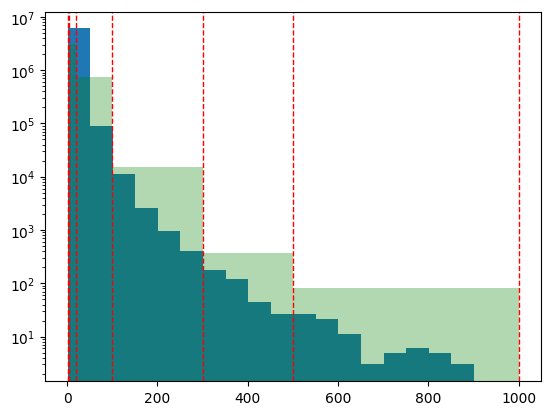

In [75]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in heuristic_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= heuristic_intervals, log = True, color= 'green', alpha = 0.3)
plt.show()

### Percentile-Based

In [10]:
percentiles = [10, 25, 50, 75, 90]
percentile_intervals = np.percentile(comments, percentiles)
percentile_intervals = np.append(percentile_intervals, 1000)
print(percentile_intervals)

lengths_stats, sum = total_score_comment(percentile_intervals, comments)
print(lengths_stats)

[   2.    3.    6.   12.   22. 1000.]
{1: {'num': 653297, 'mean': 3.0, 'std': 0.0, 'sum': 1959891}, 3: {'num': 1437158, 'mean': 9.042821318184918, 'std': 1.6753973623035274, 'sum': 12995963}, 4: {'num': 848157, 'mean': 16.57397981741588, 'std': 2.797221253679757, 'sum': 14057337}, 0: {'num': 1021167, 'mean': 1.556170538217549, 'std': 0.4968348524775116, 'sum': 1589110}, 2: {'num': 1599647, 'mean': 4.86202080834084, 'std': 0.8062276973154222, 'sum': 7777517}, 5: {'num': 596863, 'mean': 39.75942888066441, 'std': 25.037322483156345, 'sum': 23730932}}


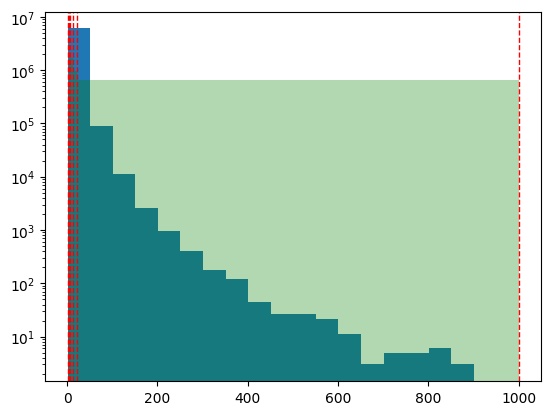

In [11]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in percentile_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= percentile_intervals, log = True, color= 'green', alpha = 0.3)
plt.show()

### Clustering-Based

In [12]:
n_intervals = 6
comment_lengths_reshaped = np.reshape(comments, (-1, 1))

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_intervals, random_state=42).fit(comment_lengths_reshaped)
clustering_intervals = np.sort(kmeans.cluster_centers_.flatten())
clustering_intervals = np.append(clustering_intervals, 1000)
print(clustering_intervals)

lengths_stats, sum = total_score_comment(clustering_intervals, comments)
print(lengths_stats)

[   4.67345803   15.67056797   32.66769236   61.38853813  119.13700845
  277.30679406 1000.        ]
{0: {'num': 2319938, 'mean': 2.642698641084374, 'std': 1.084811439211619, 'sum': 6130897}, 1: {'num': 2755052, 'mean': 8.439947050001233, 'std': 2.981496905044016, 'sum': 23252493}, 2: {'num': 789346, 'mean': 21.738399890542297, 'std': 4.626813548037218, 'sum': 17159119}, 3: {'num': 229721, 'mean': 42.521036387618025, 'std': 7.741231260958477, 'sum': 9767975}, 4: {'num': 53067, 'mean': 79.42191946030489, 'std': 14.889240149804895, 'sum': 4214683}, 5: {'num': 8558, 'mean': 158.4277868660902, 'std': 36.35089190013652, 'sum': 1355825}, 6: {'num': 607, 'mean': 378.5140032948929, 'std': 115.13700478041623, 'sum': 229758}}


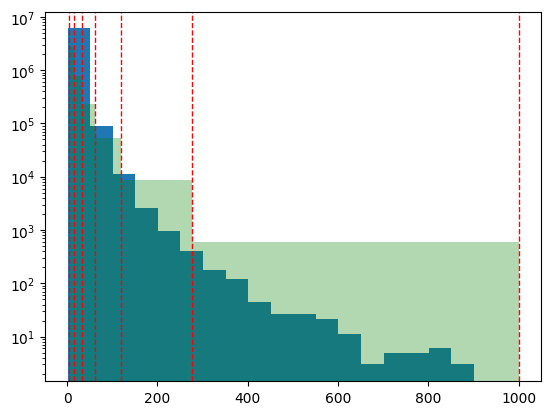

In [13]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in clustering_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= clustering_intervals, log = True, color= 'green', alpha = 0.3)
plt.show()

### Distribution of Product's Scores

In [40]:
df = digikala[['body', 'product_id']].reset_index(drop=True)
df['score'] = df['body'].apply(lambda comment: score_comment(clustering_intervals, comment))
result = df.groupby('product_id')['score'].sum().reset_index()
result.head()

,product_id,score
0,7602,227
1,12302,12
2,12423,9
3,15327,87
4,15435,170


In [41]:
result['score'].describe()

count    331599.000000
mean         15.927693
std          34.656790
min           0.000000
25%           1.000000
50%           3.000000
75%          11.000000
max         414.000000
Name: score, dtype: float64

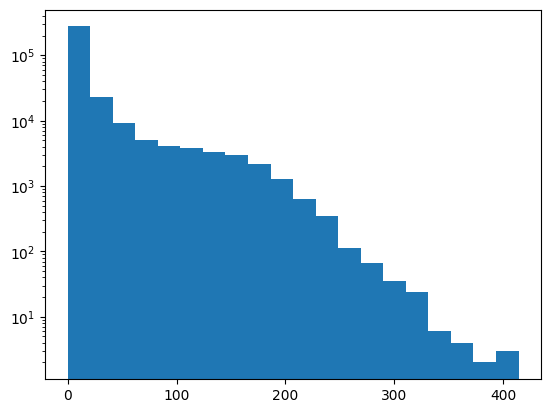

In [38]:
plt.hist(result['score'],bins= 20, log=True)
plt.show()

## Rates And Comments Grouping
We want to divide comments into positive and negative groups. In the simplest case, we do this using rates. Otherwise, we refer to the comment sentiment.

### Rates Distribution

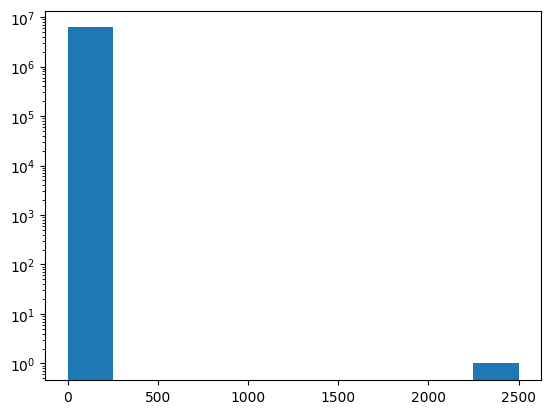

count    6.156289e+06
mean     3.648286e+00
std      1.861854e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      2.500000e+03
Name: rate, dtype: float64

In [45]:
# TODO
plt.hist(digikala['rate'])
plt.show()

### Labeling comments

In [ ]:
sentiments = pd.read_csv("sentiments.csv")
digikala = digikala.merge(sentiments, on='id')
digikala.head()

In [ ]:
def label_group(comment):
    if comment['rate'] > 3:
        return "positive"
    if 0 < comment['rate'] < 3:
        return "negative"
    return comment['sentiment']

digikala['label'] = digikala.apply(label_group, axis=1)

# Define Scoring Function

In [19]:
# GroupBy digikala data
groupde_digikala = digikala.groupby(['product_id', 'seller_title'])

## Simple Scoring

In [16]:
def score(group):
    group = group[group['is_buyer']]

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = comments / 1000
    rates_score = (group['rate'] > 0).sum()
    titles_score = group['title'].sum()
    likes_score = group['likes'].sum() + group['dislikes'].sum()
    recommended_score = group['recommendation_status'].sum()
    advantages_score = group['advantages_count'].sum() + group['disadvantages_count'].sum()
    
    total_score = (comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score)
    
    return total_score

df = groupde_digikala.apply(score).reset_index(name='score')
df.head()

C:\Users\Almas\AppData\Local\Temp\ipykernel_105616\4135825024.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = digikala.groupby(['product_id', 'seller_title']).apply(score).reset_index(name='score')


,product_id,seller_title,score
0,7602,برزان,112.040
1,7602,برهان الکترونیک,3.001
2,7602,به روز سنتر,10.003
3,7602,جانبی انسی,32.009
4,7602,جانبی حبیب,2.000


In [21]:
# Divide by total number
def score(group):
    group = group[group['is_buyer']]

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = comments / 1000
    rates_score = (group['rate'] > 0).sum()
    titles_score = group['title'].sum()
    likes_score = group['likes'].sum() + group['dislikes'].sum()
    recommended_score = group['recommendation_status'].sum()
    advantages_score = group['advantages_count'].sum() + group['disadvantages_count'].sum()
    
    total_score = (comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score) / len(group) * 100
    
    return total_score

df = groupde_digikala.apply(score).reset_index(name='score')
df.head()

C:\Users\Almas\AppData\Local\Temp\ipykernel_105616\1652106174.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = groupde_digikala.apply(score).reset_index(name='score')


,product_id,seller_title,score
0,7602,برزان,350.125
1,7602,برهان الکترونیک,300.100
2,7602,به روز سنتر,500.150
3,7602,جانبی انسی,320.090
4,7602,جانبی حبیب,200.000


In [ ]:
def score(group):
    neg_score = 0
    pos_score = 0

    for comment in group:
        if not comment['is_buyer']:
            continue
        body_score = score_comment(clustering_intervals, comment['body']) / 1000
        rate_score = 1 if comment['rate'] > 0 else 0
        title_score = comment['title']
        recommended_score = comment['recommendation_status']
        advantage_score = comment['advantages_count'] + comment['disadvantages_count']

        likes = comment['likes'] + 1  # own comment
        dislikes = comment['dislikes']
        f = likes / (likes + dislikes)
        score = body_score + rate_score + title_score + recommended_score + advantage_score

        if comment['label'] == 'positive':
            pos_score += f * score
            neg_score += score - pos_score
        else:
            neg_score += f * score
            pos_score = score - neg_score

    return score, pos_score, neg_score


df = groupde_digikala.apply(score).reset_index(name='score')
df.head()

In [93]:
df.to_csv('example.csv', encoding='utf-8')